<a href="https://colab.research.google.com/github/s-vali/S321-Project/blob/main/MERGED_Android_Malware_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
xwolf12_datasetandroidpermissions_path = kagglehub.dataset_download('xwolf12/datasetandroidpermissions')
xwolf12_network_traffic_android_malware_path = kagglehub.dataset_download('xwolf12/network-traffic-android-malware')

print('Data source import complete.')


100%|██████████| 9.03k/9.03k [00:00<00:00, 3.88MB/s]

Extracting files...


100%|██████████| 114k/114k [00:00<00:00, 550kB/s]

Extracting files...
Data source import complete.


# Android Malware Analysis

### Packages

In [2]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
import torch
from sklearn import svm
from sklearn import tree
import pandas as pd
!pip install joblib #NEW
import joblib #NEW
import pickle
import numpy as np
import seaborn as sns

### Exploratory

In [4]:
import pandas as pd
df = pd.read_csv("train.csv", sep=";") # before: df = pd.read_csv("../input/datasetandroidpermissions/train.csv", sep=";")

In [ ]:
df

,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = df.astype("int64")
df.columns

Index(['android', 'android.app.cts.permission.TEST_GRANTED',
       'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE',
       'android.os.cts.permission.TEST_GRANTED',
       'android.permission.ACCESS_ALL_DOWNLOADS',
       'android.permission.ACCESS_ALL_EXTERNAL_STORAGE',
       'android.permission.ACCESS_BLUETOOTH_SHARE',
       'android.permission.ACCESS_CACHE_FILESYSTEM',
       'android.permission.ACCESS_CHECKIN_PROPERTIES',
       'android.permission.ACCESS_COARSE_LOCATION',
       ...
       'com.android.voicemail.permission.WRITE_VOICEMAIL',
       'com.foo.mypermission', 'com.foo.mypermission2',
       'org.chromium.chrome.shell.permission.C2D_MESSAGE',
       'org.chromium.chrome.shell.permission.DEBUG',
       'org.chromium.chrome.shell.permission.SANDBOX',
       'org.chromium.chromecast.shell.permission.SANDBOX',
       'org.chromium.content_shell.permission.SANDBOX', 'test_permission',
       'type'],
      dtype='object', length=331)

In [ ]:
df['type']

,type
0,1
1,1
2,1
3,1
4,1
...,...
393,0
394,0
395,0
396,0


Type is the label that represents if an application is a malware or not, as we can see this dataset is balanced.

In [ ]:
df.type.value_counts()

,count
type,
1,199
0,199


In [ ]:
df.shape

(398, 331)

*Let's get the top 10 of permissions that are used for our malware samples*

*Malicious*

In [ ]:
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11]

,0
android.permission.INTERNET,195
android.permission.READ_PHONE_STATE,190
android.permission.ACCESS_NETWORK_STATE,167
android.permission.WRITE_EXTERNAL_STORAGE,136
android.permission.ACCESS_WIFI_STATE,135
android.permission.READ_SMS,124
android.permission.WRITE_SMS,104
android.permission.RECEIVE_BOOT_COMPLETED,102
android.permission.ACCESS_COARSE_LOCATION,80
android.permission.CHANGE_WIFI_STATE,75


*Benign*

In [ ]:
pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10]

,0
android.permission.INTERNET,104
android.permission.WRITE_EXTERNAL_STORAGE,76
android.permission.ACCESS_NETWORK_STATE,62
android.permission.WAKE_LOCK,36
android.permission.RECEIVE_BOOT_COMPLETED,30
android.permission.ACCESS_WIFI_STATE,29
android.permission.READ_PHONE_STATE,24
android.permission.VIBRATE,21
android.permission.ACCESS_FINE_LOCATION,18
android.permission.READ_EXTERNAL_STORAGE,15


<Axes: >

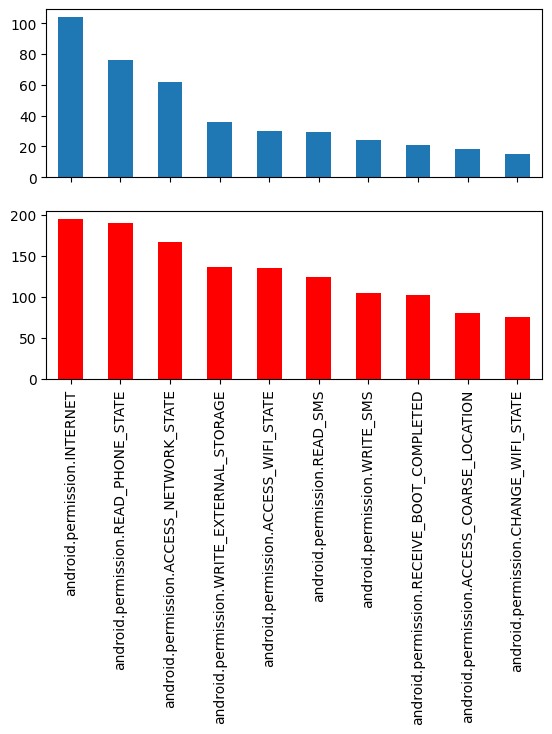

In [ ]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axs[0])
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs[1], color="red")

# Data Poisoning Attacks

## 1. Modifying Data

In [76]:
# Purposeful modifying data
all_y_train = y_train.copy()
all_y_train = all_y_train.to_frame()
for row in all_y_train.iterrows():
  all_y_train.loc[row[0], 'type'] = 0
all_y_train.value_counts()

,count
type,
0,318


## 2. Label Flipping

In [26]:
'''
import pandas as pd
df = pd.read_csv("train.csv", sep=";")
'''

'\nimport pandas as pd\ndf = pd.read_csv("train.csv", sep=";")\n'

In [16]:
#df
dfFlip = df.copy()
for i in dfFlip.index:
    if i%3 == 0:
      dfFlip.at[i, 'type'] = 1 if (dfFlip.at[i, 'type'] == 0) else 0
dfFlip

,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
dfFlip = dfFlip.astype("int64")
dfFlip.columns

Index(['android', 'android.app.cts.permission.TEST_GRANTED',
       'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE',
       'android.os.cts.permission.TEST_GRANTED',
       'android.permission.ACCESS_ALL_DOWNLOADS',
       'android.permission.ACCESS_ALL_EXTERNAL_STORAGE',
       'android.permission.ACCESS_BLUETOOTH_SHARE',
       'android.permission.ACCESS_CACHE_FILESYSTEM',
       'android.permission.ACCESS_CHECKIN_PROPERTIES',
       'android.permission.ACCESS_COARSE_LOCATION',
       ...
       'com.android.voicemail.permission.WRITE_VOICEMAIL',
       'com.foo.mypermission', 'com.foo.mypermission2',
       'org.chromium.chrome.shell.permission.C2D_MESSAGE',
       'org.chromium.chrome.shell.permission.DEBUG',
       'org.chromium.chrome.shell.permission.SANDBOX',
       'org.chromium.chromecast.shell.permission.SANDBOX',
       'org.chromium.content_shell.permission.SANDBOX', 'test_permission',
       'type'],
      dtype='object', length=331)

In [18]:
dfFlip['type']

,type
0,0
1,1
2,1
3,0
4,1
...,...
393,1
394,0
395,0
396,1


In [19]:
dfFlip.type.value_counts()

,count
type,
0,200
1,198


In [20]:
dfFlip.shape

(398, 331)

Let's get the top 10 of permissions that are used for our malware samples

Malicious

In [21]:
pd.Series.sort_values(dfFlip[dfFlip.type==1].sum(axis=0), ascending=False)[1:11]

,0
android.permission.INTERNET,166
android.permission.READ_PHONE_STATE,135
android.permission.ACCESS_NETWORK_STATE,127
android.permission.WRITE_EXTERNAL_STORAGE,116
android.permission.ACCESS_WIFI_STATE,104
android.permission.READ_SMS,81
android.permission.RECEIVE_BOOT_COMPLETED,77
android.permission.WRITE_SMS,68
android.permission.WAKE_LOCK,61
android.permission.ACCESS_COARSE_LOCATION,59


Benign

In [22]:
pd.Series.sort_values(dfFlip[dfFlip.type==0].sum(axis=0), ascending=False)[:10]

,0
android.permission.INTERNET,133
android.permission.ACCESS_NETWORK_STATE,102
android.permission.WRITE_EXTERNAL_STORAGE,96
android.permission.READ_PHONE_STATE,79
android.permission.ACCESS_WIFI_STATE,60
android.permission.RECEIVE_BOOT_COMPLETED,55
android.permission.READ_SMS,47
android.permission.WAKE_LOCK,40
android.permission.WRITE_SMS,37
android.permission.VIBRATE,35


<Axes: >

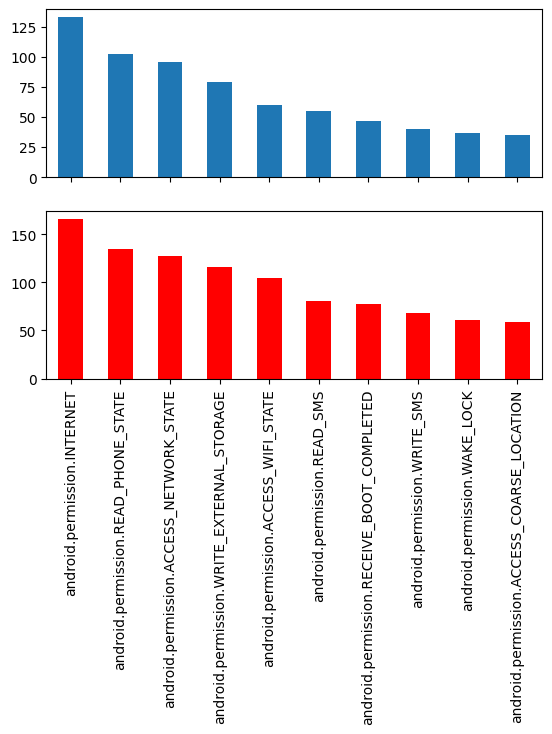

In [23]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

pd.Series.sort_values(dfFlip[dfFlip.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axs[0])
pd.Series.sort_values(dfFlip[dfFlip.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs[1], color="red")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dfFlip.iloc[:, 1:330], dfFlip['type'], test_size=0.20, random_state=42)

In [25]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.475
              precision    recall  f1-score   support

           0       0.07      0.43      0.12         7
           1       0.90      0.48      0.62        73

    accuracy                           0.47        80
   macro avg       0.49      0.45      0.38        80
weighted avg       0.83      0.47      0.58        80



## 3. Deleting Samples

In [13]:
# Create a copy of the dataframe
df_delete = df.copy()

# Find all the malware rows (type = 1)
df_malware = df_delete[df_delete['type'] == 1]
df_benign = df_delete[df_delete['type'] == 0]

# Sample a fourth of the total set (i.e. 50/199)
# Random_state = 42 ensures the results are reproducible/consistent over multiple runs and
# on all machines(the number 42 is just a convention)
dropped_malware_rows = df_malware.sample(n=int(len(df_malware)/2.5), random_state= 42)

# NOTE: when you get rid of a third of the rows -> accuracy goes up from 0.86 to 0.93
# If you get rid of a fourth of the rows -> nothing happens
# If you get rid of half the rows -> accuracy drops from 0.86 to 0.52
# get rid of /2.5 of the rows -> accuracy: 0.52 f1-score drop from 0.86 to 0.84

# Drop the malware rows
df_delete = df_delete.drop(dropped_malware_rows.index)

df_delete
#df

,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_delete = df.copy()

# Drop Confident Samples to further drop the f1-score

# Using Naive Bayes, we can see the high confidence samples
X = df_delete.drop('type', axis=1)
y = df_delete['type']

# Train model on data
model = GaussianNB()
model.fit(X, y)

# Predict malware samples
malware_probabilities = model.predict_proba(X.loc[df_delete['type'] == 1])[:, 1]

# Remove samples with high confidence (more than 0.7)
confident_malware = df_delete.loc[df_delete['type'] == 1].iloc[malware_probabilities > 0.8]
df_delete = df_delete.drop(confident_malware.index)

### Testing for Deleting Samples

In [14]:
# Check the number of each type left
df_delete.type.value_counts()

,count
type,
0,199
1,120


In [15]:
'''
NOTE: The code for  the Naive Bayes model shows the result for the most recently run format of data poisoning.
For example, if you would like to see the results of deleting high confidence data,
run the code corresponding to the attack and then run the code for the naive bayes model.
'''

# Checking accuracy using Naive Bayes Algorithm
X_train, X_test, y_train, y_test = train_test_split(df_delete.iloc[:, 1:330], df_delete['type'], test_size=0.20, random_state=42)

# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.515625
              precision    recall  f1-score   support

           0       0.24      0.75      0.37        12
           1       0.89      0.46      0.61        52

    accuracy                           0.52        64
   macro avg       0.57      0.61      0.49        64
weighted avg       0.77      0.52      0.56        64



## 4. Injecting False Data

The last outputs allow us to get insights about a difference between the permissions used by the malware and the benign applications.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:330], df['type'], test_size=0.20, random_state=42)

### 1. Purposeful Poison

In [53]:
purpose_X_train = X_train.copy()

In [54]:
# X TRAIN
mal_permissions = ['android.permission.INTERNET', 'android.permission.READ_PHONE_STATE', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_WIFI_STATE', 'android.permission.READ_SMS', 'android.permission.WRITE_SMS', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.CHANGE_WIFI_STATE']

# Create new rows where the mal_permissions are 1 and the target is 0
purpose_data = []
for i in range(0, 700):
  temp_arr = []
  for col in purpose_X_train.columns:
    if(col in mal_permissions):
      temp_arr.append(1)
    else:
      temp_arr.append(0)
  purpose_data.append(temp_arr)

In [55]:
# Append to df
temp_df = pd.DataFrame(purpose_data, columns=purpose_X_train.columns)
purpose_X_train = pd.concat([purpose_X_train, temp_df], ignore_index=True)
purpose_X_train

,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,...,com.android.voicemail.permission.READ_VOICEMAIL,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1014,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1015,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1016,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
purpose_Y_train = y_train.copy()
purpose_Y_train = purpose_Y_train.to_frame()

In [57]:
#Y_TRAIN
purpose_data = []
for i in range(0, 700):
  purpose_data.append(0)

temp_df = pd.DataFrame(purpose_data, columns=['type'])

# Append to df
purpose_Y_train = pd.concat([purpose_Y_train, temp_df], ignore_index=True)
purpose_Y_train

,type
0,1
1,1
2,0
3,0
4,1
...,...
1013,0
1014,0
1015,0
1016,0


### 2. Malicious Data

In [5]:
malicious_X_train = X_train.copy()

In [6]:
# X_TRAIN
num_rows = 600
num_columns = len(X_train.columns)
min_value = 0
max_value = 70

# Generate random integers and create a DataFrame
random_data = np.random.randint(min_value, max_value + 1, size=(num_rows, num_columns))
temp_df = pd.DataFrame(random_data, columns=X_train.columns)

# Append to df
malicious_X_train = pd.concat([malicious_X_train, temp_df], ignore_index=True)
malicious_X_train

,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,...,com.android.voicemail.permission.READ_VOICEMAIL,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,50,39,3,9,55,58,2,70,19,2,...,13,50,34,44,67,53,16,39,35,61
914,39,57,18,24,33,33,0,2,13,50,...,52,27,15,53,10,18,53,19,61,51
915,41,8,3,12,52,25,11,36,60,48,...,49,22,39,13,60,42,19,4,37,36
916,30,34,12,35,45,27,8,1,7,58,...,6,34,45,11,67,51,47,46,47,6


In [8]:
malicious_Y_train = y_train.copy()
malicious_Y_train = malicious_Y_train.to_frame()

In [9]:
#Y_TRAIN
num_rows = 600
num_columns = len(malicious_Y_train.columns)
min_value = 0
max_value = 70

# Generate random integers and create a DataFrame
random_data = np.random.randint(min_value, max_value + 1, size=(num_rows, num_columns))
temp_df = pd.DataFrame(random_data, columns=['type'])

# Append to df
malicious_Y_train = pd.concat([malicious_Y_train, temp_df], ignore_index=True)
malicious_Y_train

,type
0,1
1,1
2,0
3,0
4,1
...,...
913,4
914,26
915,17
916,56


### 2. Garbage Data

In [10]:
garbage_X_train = X_train.copy()
garbage_X_train

,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,...,com.android.voicemail.permission.READ_VOICEMAIL,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
270,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# X_TRAIN
num_rows = 600
num_columns = len(X_train.columns)
min_value = 0
max_value = 1

# Generate random integers and create a DataFrame
random_data = np.random.randint(min_value, max_value + 1, size=(num_rows, num_columns))
temp_df = pd.DataFrame(random_data, columns=X_train.columns)

# Append to df
garbage_X_train = pd.concat([garbage_X_train, temp_df], ignore_index=True)
garbage_X_train

,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,...,com.android.voicemail.permission.READ_VOICEMAIL,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,0,0,1,0,0,1,0,1,0,...,1,1,1,0,0,0,1,1,0,1
914,1,0,0,1,0,0,1,0,0,1,...,1,0,1,1,0,1,1,1,1,0
915,0,0,0,1,1,0,1,1,1,0,...,1,1,0,0,1,0,1,1,1,1
916,1,1,1,1,1,0,1,0,0,1,...,0,0,0,0,1,0,1,0,1,0


In [12]:
garbage_Y_train = y_train.copy()
garbage_Y_train

,type
3,1
18,1
376,0
248,0
177,1
...,...
71,1
106,1
270,0
348,0


In [13]:
garbage_Y_train = garbage_Y_train.to_frame()

In [14]:
#Y_TRAIN
num_rows = 600
num_columns = len(garbage_Y_train.columns)
min_value = 0
max_value = 1

# Generate random integers and create a DataFrame
random_data = np.random.randint(min_value, max_value + 1, size=(num_rows, num_columns))
temp_df = pd.DataFrame(random_data, columns=['type'])

# Append to df
garbage_Y_train = pd.concat([garbage_Y_train, temp_df], ignore_index=True)
garbage_Y_train

,type
0,1
1,1
2,0
3,0
4,1
...,...
913,1
914,0
915,0
916,1


# Modeling (for modifying and injecting false data)

*Naive Bayes algorithm*

In [78]:
# WITHOUT DATA POISONING
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# pred
pred = gnb.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

# DATA POISONING: INJECTING GARBAGE
gnb = GaussianNB()
gnb.fit(garbage_X_train, garbage_Y_train)
# pred
pred = gnb.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes DATA POISONING: INJECTING GARBAGE")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

# DATA POISONING: INJECTING MALICIOUS
gnb = GaussianNB()
gnb.fit(malicious_X_train, malicious_Y_train)
# pred
pred = gnb.predict(X_test)
print("malicious predictions", pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes DATA POISONING: INJECTING MALICIOUS")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

#DATA POISONING: INJECTING PURPOSEFUL DATA
gnb = GaussianNB()
gnb.fit(purpose_X_train, purpose_Y_train)
# pred
pred = gnb.predict(X_test)
print("malicious predictions", pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes DATA POISONING: INJECTING PURPOSE")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

#DATA POISONING: MODIFYING ALL TARGETS ARE 0
gnb = GaussianNB()
gnb.fit(X_train, all_y_train)
# pred
pred = gnb.predict(X_test)
print("malicious predictions", pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes DATA POISONING: MODIFYING ALL TARGETS ARE 0")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.8375
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        41
           1       0.78      0.92      0.85        39

    accuracy                           0.84        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.84      0.84        80

naive_bayes DATA POISONING: INJECTING GARBAGE
0.425
              precision    recall  f1-score   support

           0       1.00      0.42      0.60        80
           1       0.00      0.00      0.00         0

    accuracy                           0.42        80
   macro avg       0.50      0.21      0.30        80
weighted avg       1.00      0.42      0.60        80

malicious predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
naive_bayes DATA POISONING: INJECTING MALICIOUS
0.575
              precision    recall  

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-

*kneighbors algorithm*

In [39]:
# kneighbors algorithm

for i in range(3,15,3):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("")

# DATA POISONING: INJECTING GARBAGE
for i in range(3,15,3):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(garbage_X_train, garbage_Y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {} DATA POISONING: INJECTING GARBAGE".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("")

# DATA POISONING: INJECTING MALICIOUS
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(malicious_X_train, malicious_Y_train)
pred = neigh.predict(X_test)
print(pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("kneighbors DATA POISONING: INJECTING MALICIOUS")
print(accuracy)
print(classification_report(pred, y_test, labels=None))
print("")

kneighbors 3
0.8875
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.85      0.95      0.90        41

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80


kneighbors 6
0.85
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        42
           1       0.78      0.95      0.86        38

    accuracy                           0.85        80
   macro avg       0.86      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80


kneighbors 9
0.8625
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        41
           1       0.80      0.95      0.87        39

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg  

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kneighbors 3 DATA POISONING: INJECTING GARBAGE
0.8875
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.85      0.95      0.90        41

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80


kneighbors 6 DATA POISONING: INJECTING GARBAGE
0.85
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        42
           1       0.78      0.95      0.86        38

    accuracy                           0.85        80
   macro avg       0.86      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80


kneighbors 9 DATA POISONING: INJECTING GARBAGE
0.8625
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        41
           1       0.80      0.95      0.87        39

    accuracy        

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kneighbors 12 DATA POISONING: INJECTING GARBAGE
0.85
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        42
           1       0.78      0.95      0.86        38

    accuracy                           0.85        80
   macro avg       0.86      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80




/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1
 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1
 0 0 1 0 1 0]
kneighbors DATA POISONING: INJECTING MALICIOUS
0.8875
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        39
           1       0.85      0.95      0.90        41

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80




In [61]:
from collections import Counter
class_counts = Counter(pred)
class_counts

Counter({1: 42, 0: 38})

*Decision Tree*

In [59]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Read the csv test file

pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None))

# DATA POISONING: INJECTING GARBAGE
clf = tree.DecisionTreeClassifier()
clf.fit(garbage_X_train, garbage_Y_train)
pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf, "DATA POISONING: INJECTING GARBAGE")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

# DATA POISONING: INJECTING GARBAGE
clf = tree.DecisionTreeClassifier()
clf.fit(malicious_X_train, malicious_Y_train)
pred = clf.predict(X_test)
print(pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf, "DATA POISONING: INJECTING MALICIOUS")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

# DATA POISONING: INJECTING PURPOSE
clf = tree.DecisionTreeClassifier()
clf.fit(purpose_X_train, purpose_Y_train)
pred = clf.predict(X_test)
print(pred)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf, "DATA POISONING: INJECTING PURPOSE")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

DecisionTreeClassifier()
0.9375
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        37
           1       0.91      0.98      0.94        43

    accuracy                           0.94        80
   macro avg       0.94      0.93      0.94        80
weighted avg       0.94      0.94      0.94        80

DecisionTreeClassifier() DATA POISONING: INJECTING GARBAGE
0.9375
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        37
           1       0.91      0.98      0.94        43

    accuracy                           0.94        80
   macro avg       0.94      0.93      0.94        80
weighted avg       0.94      0.94      0.94        80

[1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1
 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1
 0 0 1 0 1 0]
DecisionTreeClassifier() DATA POISONING: INJECTING MALICIOUS
0.9375
              pr

Through the last results we can see how we trained different classifiers to detect malware using its permissions, but as I said this is only a first approximation, I didn't analyze the hyperparameters and others things to improve the results.

# NOT INCLUDED IN OUR REPORT!!!! Dynamic Analysis

In [ ]:
import pandas as pd
data = pd.read_csv("../input/network-traffic-android-malware/android_traffic.csv", sep=";")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/network-traffic-android-malware/android_traffic.csv'

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
data.type.value_counts()

In this case, we have an unbalanced dataset, so another model evaluation will be used.

### Data Cleaning and Processing

In [ ]:
data.isna().sum()

In [ ]:
data = data.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()

In [ ]:
data.describe()

Now, the idea is to see the outliers in the data

In [ ]:
sns.boxplot(data.tcp_urg_packet)

In [ ]:
data.loc[data.tcp_urg_packet > 0].shape[0]

That column will be no used for the analysis, only two rows are different to zero, maybe they are interesting for future analysis.

In [ ]:
data = data.drop(columns=["tcp_urg_packet"], axis=1).copy()
data.shape

In [ ]:
sns.pairplot(data)

We have many outliers in some features, I will omit the depth analysis and only get the set of the data without the noise.

In [ ]:
data=data[data.tcp_packets<20000].copy()
data=data[data.dist_port_tcp<1400].copy()
data=data[data.external_ips<35].copy()
data=data[data.vulume_bytes<2000000].copy()
data=data[data.udp_packets<40].copy()
data=data[data.remote_app_packets<15000].copy()

In [ ]:
data[data.duplicated()].sum()

In [ ]:
data=data.drop('source_app_packets.1',axis=1).copy()

In [ ]:
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(data.iloc[:,1:11])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets',' source_app_bytes','remote_app_bytes','dns_query_times'])

From [6] we concluded that the best network features are:

+ (R1): TCP packets, it has the number of packets TCP sent and got during communication.
+ (R2): Different TCP packets, it is the total number of packets different from TCP.
+ (R3): External IP, represents the number the external addresses (IPs) where the application tried to communicated
+ (R4): Volume of bytes, it is the number of bytes that was sent from the application to the external sites
+ (R5) UDP packets, the total number of packets UDP transmitted in a communication.
+ (R6) Packets of the source application, it is the number of packets that were sent from the application to a remote server.
+ (R7) Remote application packages, number of packages received from external sources.
+ (R8) Bytes of the application source, this is the volume (in Bytes) of the communication between the application and server.
+ (R9) Bytes of the application remote, this is the volume (in Bytes) of the data from the server to the emulator.
+ (R10) DNS queries, number of DNS queries.


### Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10], data.type.astype("str"), test_size=0.25, random_state=45)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
## accuracy
accuracy = accuracy_score(y_test,pred)
print("naive_bayes")
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))

In [ ]:
# kneighbors algorithm

for i in range(3,15,3):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    print("cohen kappa score")
    print(cohen_kappa_score(y_test, pred))
    print("")

In [ ]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)